In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
colab_dir = '/content/gdrive/My Drive/Colab_files/2022_CCS_case_study'
sys.path.append(colab_dir)

In [ ]:
 !pip install geopandas
 !pip install adjustText
 !pip install shapely

In [48]:
%matplotlib inline

from datetime import datetime
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
plt.style.use('seaborn')
import pandas as pd
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely import wkt
from adjustText import adjust_text

# Read data for the case study challeng


*   define rural areas: raws with NaN for either PCUID, PCNAME, PCTYPE, or PCCLASS (Population centre ID, Population centre name, Population centre type, Population centre size class).
*   filter out urban areas
*   Get summary stats: count # test per area (Provinces, Census divisions, dissemination areas) to choose resolution for a model

tile < dissemination area < Census division <= (?) Municipalities < Provinces

In [8]:
df = pd.read_csv(colab_dir+'/ookla-canada-speed-tiles.csv')
df['is_rural'] = np.where(df.PCTYPE.isna(), True, False)
print(df.size)
df_rural = df[df['is_rural']]
print(df_rural.size)

60532208
32975888


In [9]:
del(df)

In [11]:
print(df_rural.size)
print(df_rural.columns)
print(df_rural.geometry[1])
# exclude useless NaN columns
df_rural = df_rural.loc[:, ~df_rural.columns.isin(['PCUID', 'PCNAME', 'PCTYPE', 'PCCLASS', 'is_rural'])]
df_rural.head(2)

26980272
Index(['quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests', 'devices',
       'year', 'quarter', 'conn_type', 'PRUID', 'PRNAME', 'CDUID', 'CDNAME',
       'DAUID', 'SACTYPE', 'DA_POP', 'geometry', 'is_rural'],
      dtype='object')
POLYGON ((4592705.709263269 4089714.237789153, 4592877.873838898 4089575.435803925, 4592739.201972298 4089403.417421044, 4592567.022541305 4089542.231382916, 4592705.709263269 4089714.237789153))


,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter,conn_type,PRUID,PRNAME,CDUID,CDNAME,DAUID,SACTYPE,DA_POP,geometry
0,23331133131332,11910,1408,27,1,1,2019,Q1,fixed,61,Northwest Territories / Territoires du Nord-Ouest,6101,Region 1,61010033,8,590.0,"POLYGON ((4593360.869162522 4089469.903958718,..."
1,23331133133011,14969,1554,25,1,1,2019,Q1,fixed,61,Northwest Territories / Territoires du Nord-Ouest,6101,Region 1,61010033,8,590.0,"POLYGON ((4592705.709263269 4089714.237789153,..."


In [21]:
print(pd.unique(df_rural.PRNAME))
print(pd.unique(df_rural.PRNAME).size)
print(pd.unique(df_rural.quarter))
print(pd.unique(df_rural.year))
print(pd.unique(df_rural.conn_type))

['Northwest Territories / Territoires du Nord-Ouest' 'Yukon'
 'British Columbia / Colombie-Britannique' 'Alberta' 'Saskatchewan'
 'Manitoba' 'Ontario'
 'Newfoundland and Labrador / Terre-Neuve-et-Labrador' 'Quebec / Québec'
 'New Brunswick / Nouveau-Brunswick' 'Nova Scotia / Nouvelle-Écosse'
 'Prince Edward Island / Île-du-Prince-Édouard' 'Nunavut']
13
['Q1' 'Q2' 'Q3' 'Q4']
[2019 2020 2021]
['fixed' 'mobile']


In [ ]:
df_rural['date'] = pd.to_datetime(df_rural.year.map(str) + "-" + df_rural.quarter.map(str))

In [78]:
def get_stat_lon(in_df, in_group_list):
  # get longitudinal summary data grouping by in_group_col 
  in_df['avg_d_mbps'] = in_df['avg_d_kbps'] / 1000
  in_df['avg_u_mbps'] = in_df['avg_u_kbps'] / 1000

  county_stats = (
    in_df.groupby(in_group_list)
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"]),
             "avg_u_mbps_wt": np.average(x["avg_u_mbps"], weights=x["tests"]),
             "avg_lat_ms": np.average(x["avg_lat_ms"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        in_df.groupby(in_group_list)
        .agg(tests=("tests", "sum"), DA_POP=("DA_POP", "sum"))
        .reset_index(),
        on=in_group_list,
    )
  )
  return county_stats

tests_stat = get_stat_lon(df_rural, ['date','PRNAME'])
tests_stat.head()

,date,PRNAME,avg_d_mbps_wt,avg_u_mbps_wt,avg_lat_ms,tests,DA_POP
0,2019-01-01,Alberta,40.212451,11.204963,62.211769,58932,11764725.0
1,2019-01-01,British Columbia / Colombie-Britannique,70.499636,17.061409,54.903333,38348,5815630.0
2,2019-01-01,Manitoba,31.230057,8.722246,52.016850,21662,3680690.0
3,2019-01-01,New Brunswick / Nouveau-Brunswick,71.136766,40.342223,61.132572,7181,1236780.0
4,2019-01-01,Newfoundland and Labrador / Terre-Neuve-et-Lab...,61.433392,26.599225,49.313198,5728,766695.0


Text(0.5, 1.0, 'Population size')

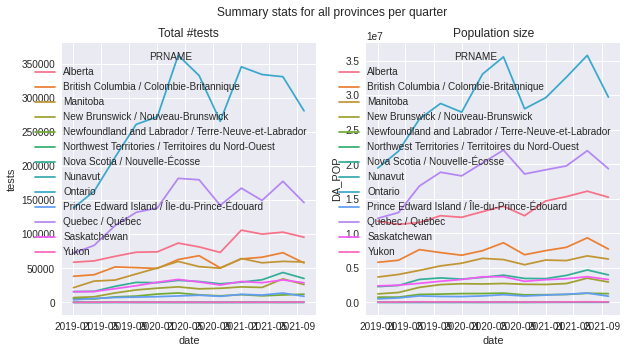

In [81]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
fig.suptitle('Summary stats for all provinces per quarter')

# overall # tests per period and province
sns.lineplot(ax=axes[0], data=tests_stat, x="date", y="tests", hue = 'PRNAME')
axes[0].set_title("Total #tests")

# population size
sns.lineplot(ax=axes[1], data=tests_stat, x="date", y="DA_POP", hue = 'PRNAME')
axes[1].set_title("Population size")

Text(0.5, 1.0, 'average latency')

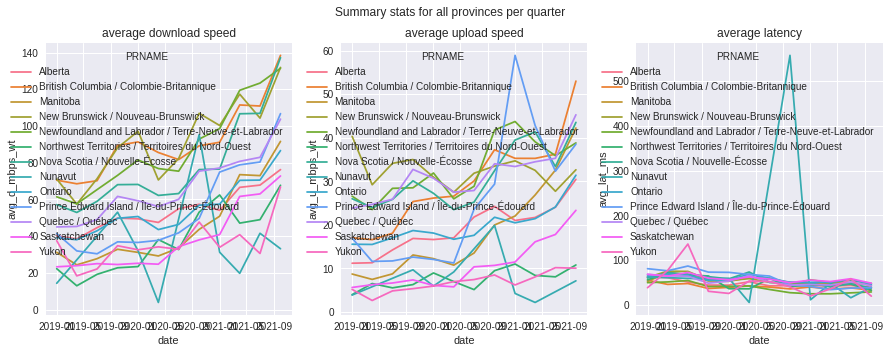

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Summary stats for all provinces per quarter')

# average download speed of all speed tests taken from a tile (in mbps)
sns.lineplot(ax=axes[0], data=tests_stat, x="date", y="avg_d_mbps_wt", hue = 'PRNAME')
axes[0].set_title("average download speed")

# average upload speed of all speed tests taken from a tile (in mbps)
sns.lineplot(ax=axes[1], data=tests_stat, x="date", y="avg_u_mbps_wt", hue = 'PRNAME')
axes[1].set_title("average upload speed")

# average latency of all speed tests taken from a tile (in milliseconds)
sns.lineplot(ax=axes[2], data=tests_stat, x="date", y="avg_lat_ms", hue = 'PRNAME')
axes[2].set_title("average latency")

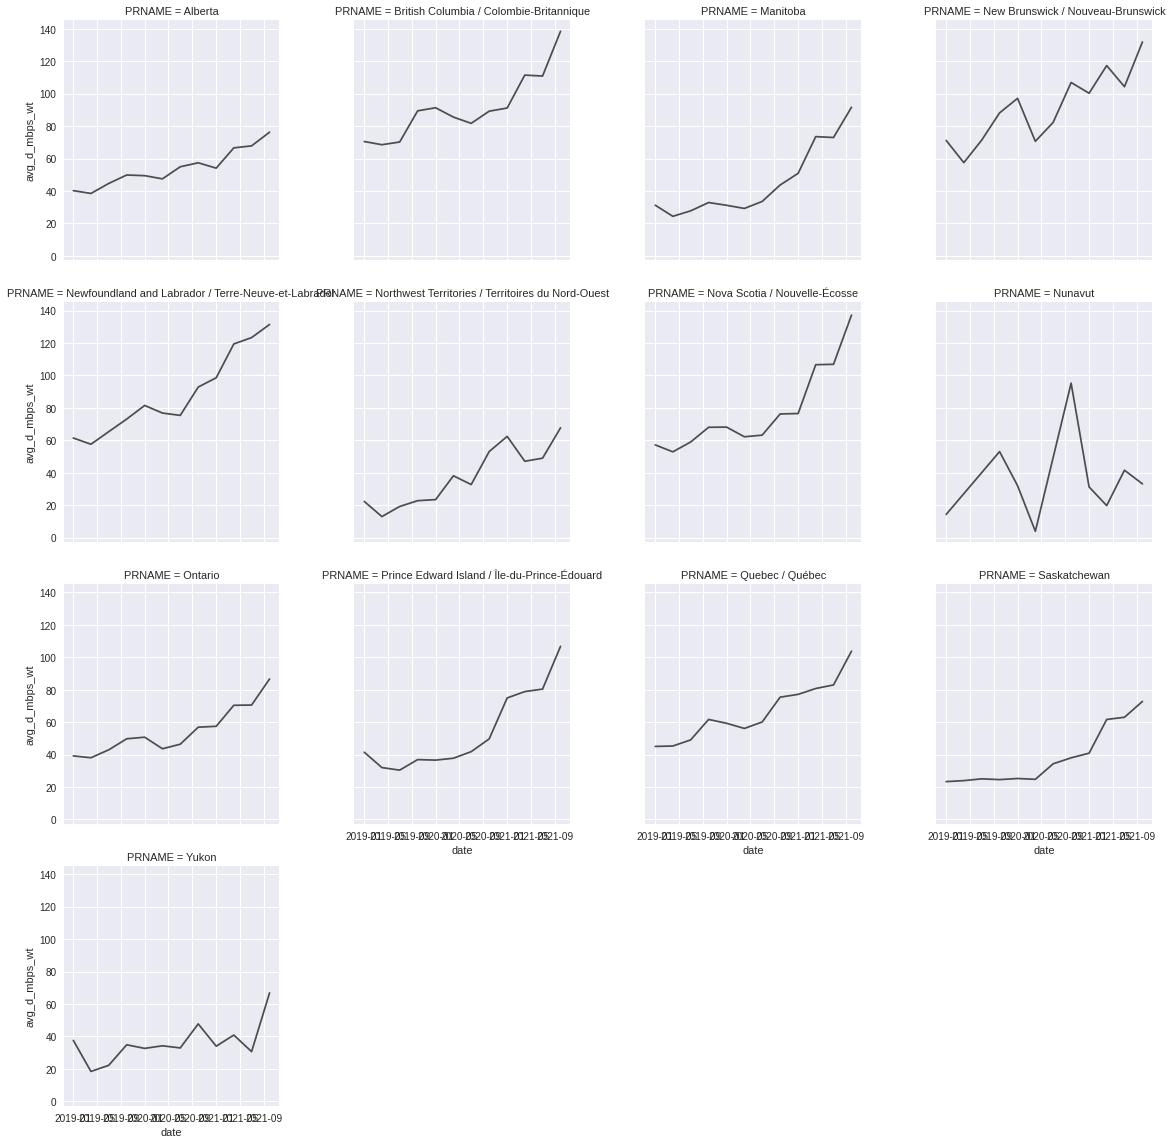

In [72]:
# average download speed of all speed tests taken from a tile (in mbps)
g = sns.FacetGrid(tests_stat, col="PRNAME", col_wrap=4, height=4)
g.map(sns.lineplot, "date", "avg_d_mbps_wt", color=".3", ci=None)

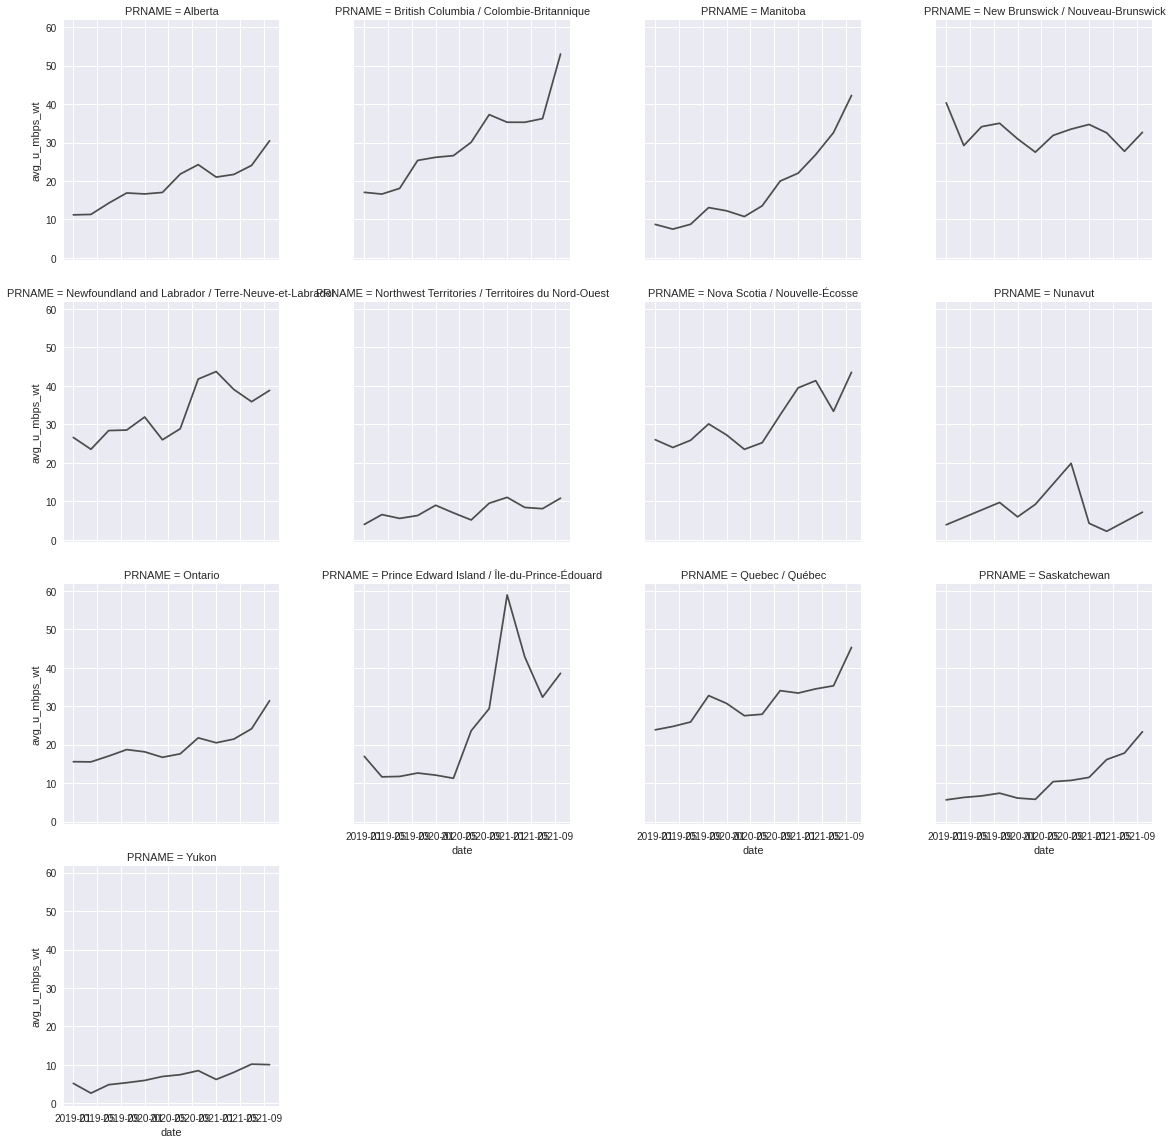

In [73]:
g = sns.FacetGrid(tests_stat, col="PRNAME", col_wrap=4, height=4)
g.map(sns.lineplot, "date", "avg_u_mbps_wt", color=".3", ci=None)

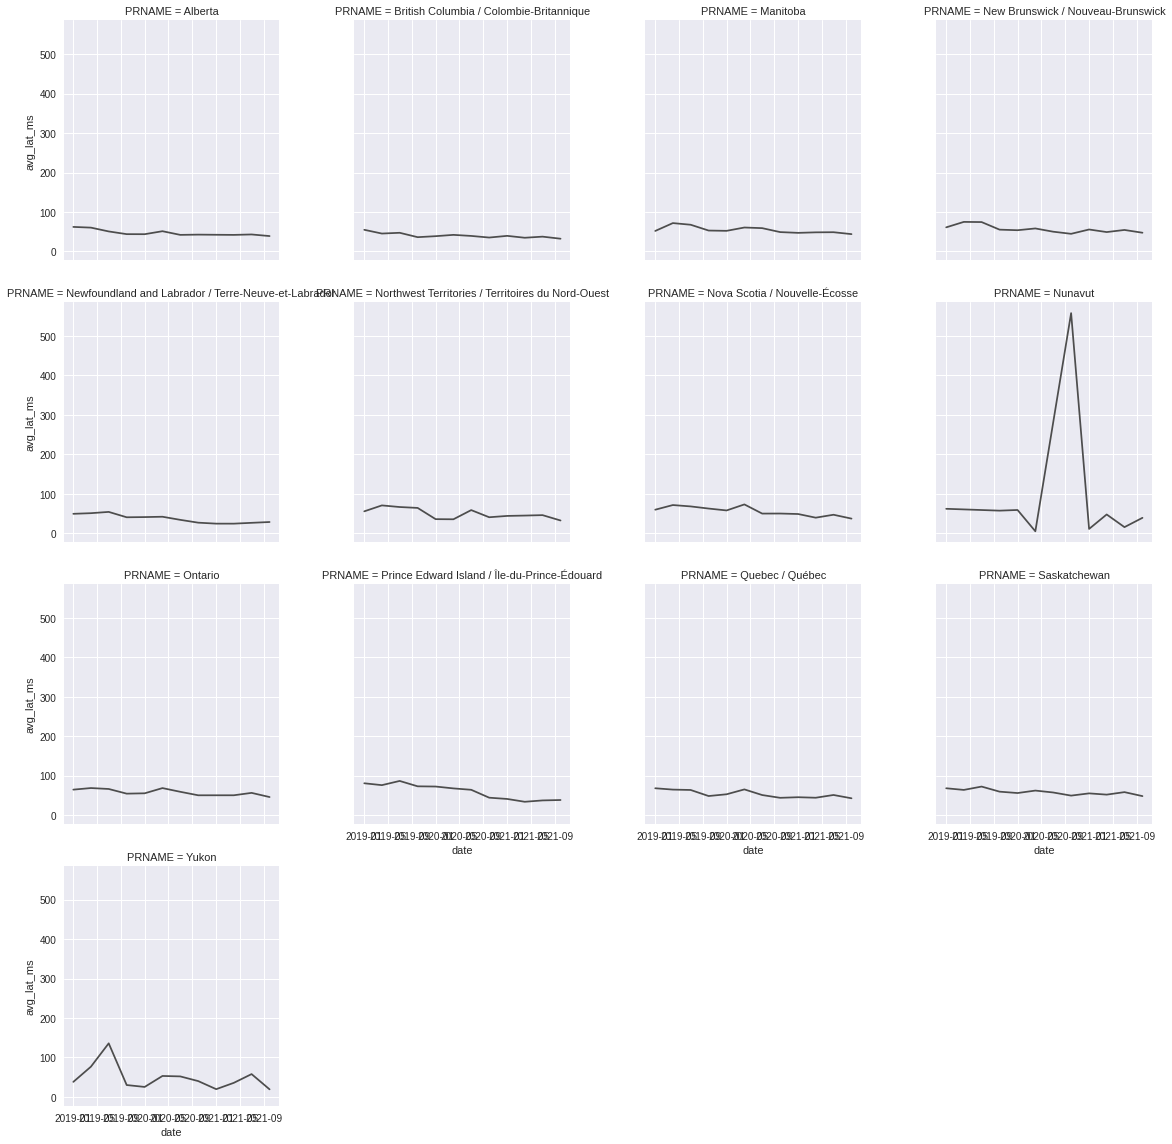

In [74]:
g = sns.FacetGrid(tests_stat, col="PRNAME", col_wrap=4, height=4)
g.map(sns.lineplot, "date", "avg_lat_ms", color=".3", ci=None)

# Some observations:


*   Unbalanced sample size in terms of # tests
*   Trends for response variables differ: noisy for provinces with less observations ('Northwest Territories / Territoires du Nord-Ouest' 'Yukon'
  'Newfoundland and Labrador / Terre-Neuve-et-Labrador' 
 'New Brunswick / Nouveau-Brunswick' 'Nova Scotia / Nouvelle-Écosse'
 'Prince Edward Island / Île-du-Prince-Édouard' 'Nunavut')



In [75]:
# stratify by connection type 
tests_stat = get_stat_lon(df_rural, ['date','PRNAME', 'conn_type'])
tests_stat.head()

,date,PRNAME,conn_type,avg_d_mbps_wt,avg_u_mbps_wt,avg_lat_ms,tests
0,2019-01-01,Alberta,fixed,39.576082,11.183496,62.971669,56192
1,2019-01-01,Alberta,mobile,53.263132,11.645213,46.627737,2740
2,2019-01-01,British Columbia / Colombie-Britannique,fixed,71.267530,17.314030,55.026995,37007
3,2019-01-01,British Columbia / Colombie-Britannique,mobile,49.308406,10.089922,51.490679,1341
4,2019-01-01,Manitoba,fixed,30.908648,8.746274,51.418842,20571


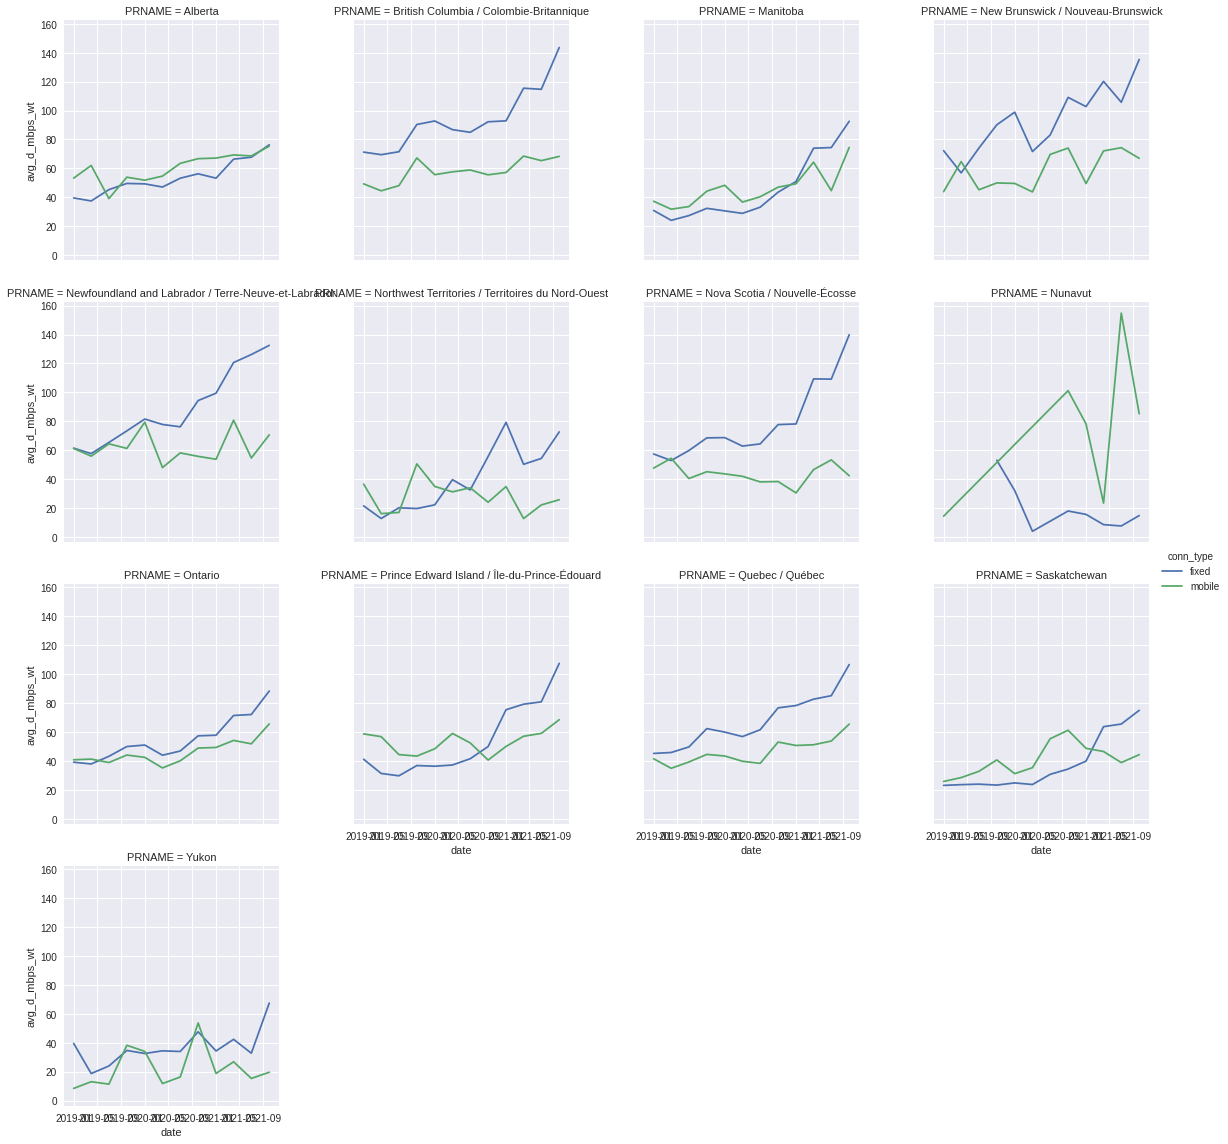

In [77]:
# average download speed of all speed tests taken from a tile (in mbps)
g = sns.FacetGrid(tests_stat, hue = 'conn_type', col="PRNAME", col_wrap=4, height=4)
g.map(sns.lineplot, "date", "avg_d_mbps_wt", ci=None)
g.add_legend()

# Suggestion for a regression model:


*   Aggregation level: Census division (see # divisions per province below). We have 2-41913 observations per Census division.
*   Response variables: avg_d_mbps_wt	avg_u_mbps_wt	avg_lat_ms	
*   Covariates: date, PRNAME/PRUID, CDUID/CDNAME, DA_POP, conn_type 



In [102]:
agg_df = df_rural.groupby(['PRNAME','CDUID']).size().reset_index().rename(columns={0:'Census division count'})
agg_df = agg_df[['PRNAME','CDUID']]
agg_df.groupby(['PRNAME']).size().reset_index().rename(columns={0:'Census division count'})

,PRNAME,Census division count
0,Alberta,19
1,British Columbia / Colombie-Britannique,29
2,Manitoba,23
3,New Brunswick / Nouveau-Brunswick,15
4,Newfoundland and Labrador / Terre-Neuve-et-Lab...,11
5,Northwest Territories / Territoires du Nord-Ouest,6
6,Nova Scotia / Nouvelle-Écosse,18
7,Nunavut,3
8,Ontario,49
9,Prince Edward Island / Île-du-Prince-Édouard,3


In [113]:
agg_df = df_rural.groupby(['PRNAME','CDUID']).size().reset_index().rename(columns={0:'observations'})
print(agg_df.head())
print('\nsummary for observations per Census division for all quarterts')
agg_df.observations.describe()

    PRNAME  CDUID  observations
0  Alberta   4801          4024
1  Alberta   4802          7932
2  Alberta   4803          4981
3  Alberta   4804          1782
4  Alberta   4805          8147

summary for observations per Census division for all quarterts


count      293.000000
mean      5115.713311
std       5111.597047
min          2.000000
25%       1913.000000
50%       3459.000000
75%       6843.000000
max      41913.000000
Name: observations, dtype: float64

# Prepare dataset with aggregation data for all provinces and all quarters

In [114]:
# stratify by connection type
tests_stat = get_stat_lon(df_rural, ['date','PRNAME', 'CDUID', 'conn_type'])
tests_stat.head()

,date,PRNAME,CDUID,conn_type,avg_d_mbps_wt,avg_u_mbps_wt,avg_lat_ms,tests,DA_POP
0,2019-01-01,Alberta,4801,fixed,51.526124,8.122863,41.877760,1268,246025.0
1,2019-01-01,Alberta,4801,mobile,28.724486,7.500324,41.990991,111,17665.0
2,2019-01-01,Alberta,4802,fixed,73.372543,23.685970,31.992920,2401,550175.0
3,2019-01-01,Alberta,4802,mobile,48.640338,10.227563,34.239437,71,46090.0
4,2019-01-01,Alberta,4803,fixed,35.298657,14.609983,42.278186,1632,226350.0


In [115]:
tests_stat.to_csv(colab_dir+'/canada_aggregation_divisions.csv')